In [56]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 200)

In [57]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"

In [58]:
import git
git = git.Git("../../../sonarqube/") 

### Import all tag comparisons dataset

In [59]:
compare_tags = pd.read_csv(f"{csv_folder}/compare_tags_sha.csv", index_col=0)
compare_tags.head(2)

,from_tag,from_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_date
0,8.4.2.36762,2020-08-27 14:11:31,2de1f343e3dbd9e88007b42e475512677c04eb8a,a0d372f704998d38856c26e28662fd7de062f873,0,4,8.4.1.35646,2020-07-14 08:13:18
1,8.4.0.35506,2020-07-03 07:09:27,74b4533439f380827d68e8c01667eeaecad89fc7,a0d372f704998d38856c26e28662fd7de062f873,6,0,8.4.1.35646,2020-07-14 08:13:18


### Import tags

In [60]:
tags = pd.read_csv(f"{csv_folder}/tags.csv", index_col=0)
tags.Date = pd.to_datetime(tags.Date)
tags["month"] = tags.Date.dt.month
tags["year"] = tags.Date.dt.year
tags = tags.tail(-1)
tags.head()

,Tag,Sha,Date,Tag_number,month,year
1,8.4.2.36762,2de1f343e3dbd9e88007b42e475512677c04eb8a,2020-08-27 14:11:31,8.4.2.36762,8,2020
2,8.4.1.35646,a0d372f704998d38856c26e28662fd7de062f873,2020-07-14 08:13:18,8.4.1.35646,7,2020
3,8.4.0.35506,74b4533439f380827d68e8c01667eeaecad89fc7,2020-07-03 07:09:27,8.4.0.35506,7,2020
4,8.3.1.34397,b77ce511a2039330aea8832ad12e86a8cfa9ff7d,2020-05-07 12:09:22,8.3.1.34397,5,2020
5,8.3.0.34182,9c58e36328ae79ad3c36c13aa253879351ce3613,2020-04-28 13:54:13,8.3.0.34182,4,2020


### Shape

In [61]:
tags.shape

(185, 6)

### Columns

In [62]:
tags.columns

Index(['Tag', 'Sha', 'Date', 'Tag_number', 'month', 'year'], dtype='object')

### Filter the ones after the project started using TravisCI

In [63]:
tags = tags[tags.Date > "2015-03-10"]

In [64]:
tags.Tag.nunique()

120

### Statistical summary

In [65]:
tags.describe()

,month,year
count,120.000000,120.00000
mean,5.566667,2016.75000
std,3.633951,1.34258
min,1.000000,2015.00000
25%,2.000000,2016.00000
50%,5.000000,2016.00000
75%,8.250000,2017.00000
max,12.000000,2020.00000


**Distribution over the years**

<AxesSubplot:xlabel='year', ylabel='Tag'>

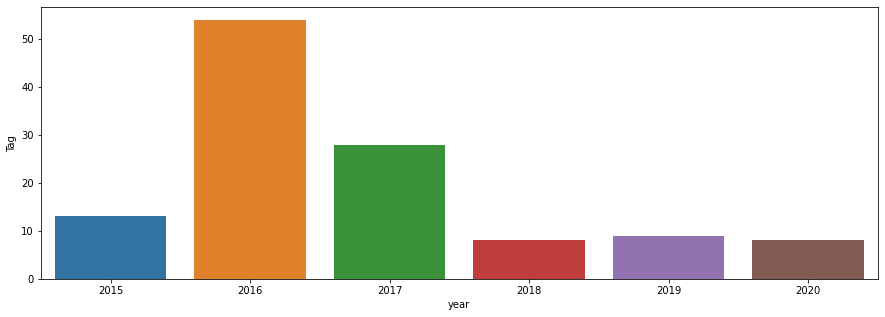

In [66]:
sns.barplot(x="year", y="Tag", data=tags.groupby("year").Tag.count().reset_index())

**Distribution overtime of the releases**

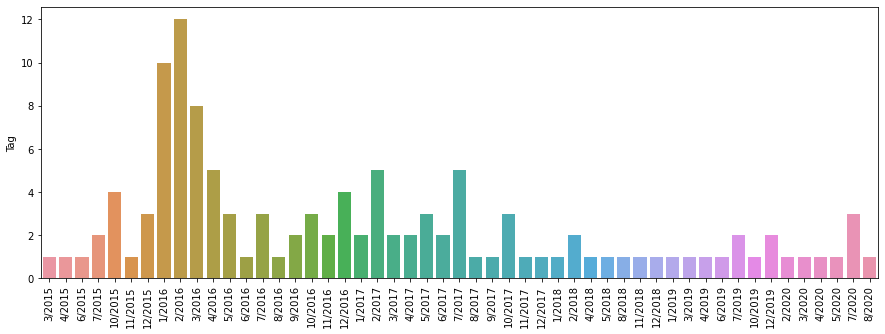

In [67]:
time_group = ["year", "month"]
x = tags.groupby(time_group).Tag.count().reset_index()
ax = sns.barplot(x=x.index, y=x.Tag)
ax.set_xticklabels(list(x[time_group[1]].astype(int).astype(str) + "/" + x[time_group[0]].astype(int).astype(str)),
                      rotation=90)
plt.show()

**Major version counts**

In [68]:
tags["major_version"] = tags.Tag.apply(lambda s: s.split(".")[0])

In [69]:
tags.major_version.value_counts(normalize=True)

5    0.466667
6    0.350000
7    0.091667
8    0.066667
4    0.025000
Name: major_version, dtype: float64

Text(0, 0.5, 'Tags')

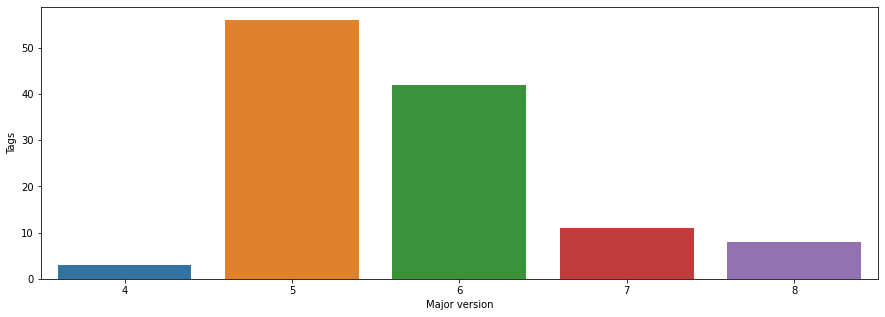

In [70]:
ax = sns.countplot(x=tags.major_version.sort_values())
ax.set_xlabel("Major version")
ax.set_ylabel("Tags")

### Import tag comparison pairs

In [71]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison.head()

,from_tag,from_author_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_author_date,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days
2307,4.5.5,2015-07-30 10:02:58,cc8a9472c671598fb3158b51b15863448a477a50,12d931e5a31e1692a428bbb34ba11cd63aebf998,16,0,4.5.6,2015-10-16 09:31:18,16,77 days 23:28:20,77.978009,2015-07-30 12:02:58,2015-10-16 11:31:18,77 days 23:28:20,77.978009
2296,4.5.6,2015-10-16 09:31:18,12d931e5a31e1692a428bbb34ba11cd63aebf998,e2afb0bff1b8be759789d2c1bc9348de6f519f83,7,0,4.5.7,2016-04-08 13:44:39,7,175 days 04:13:21,175.175938,2015-10-16 11:31:18,2016-04-08 15:44:39,175 days 04:13:21,175.175938
2257,5.1,2015-04-02 08:09:45,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,7,0,5.1.1,2015-06-02 08:34:06,7,61 days 00:24:21,61.016910,2015-04-02 10:09:45,2015-06-02 10:34:06,61 days 00:24:21,61.016910
2271,5.1-RC2,2015-03-23 15:22:47,dfc9f94b72103ee941cc11da6529623fa91df509,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,17,0,5.1,2015-04-02 08:09:45,17,9 days 16:46:58,9.699282,2015-03-23 16:22:47,2015-04-02 10:09:45,9 days 17:46:58,9.740949
2242,5.1.1,2015-06-02 08:34:06,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,12,0,5.1.2,2015-07-27 08:03:21,12,54 days 23:29:15,54.978646,2015-06-02 10:34:06,2015-07-27 10:03:21,54 days 23:29:15,54.978646


### Statistical summary

In [85]:
tags_comparison.describe()

,ahead_by,behind_by,ahead_behind_sum,diff_author_days,diff_commit_days,to_commit_date_month,to_commit_date_year
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,141.726496,0.068376,141.794872,30.812429,29.903889,5.581197,2016.794872
std,358.064279,0.314218,358.083609,47.609832,46.746896,3.677141,1.329626
min,1.000000,0.000000,1.000000,-4.988113,-4.988113,1.000000,2015.000000
25%,9.000000,0.000000,9.000000,4.230324,3.982072,2.000000,2016.000000
50%,21.000000,0.000000,21.000000,9.880231,9.740949,5.000000,2016.000000
75%,64.000000,0.000000,64.000000,42.885694,42.927361,9.000000,2017.000000
max,2762.000000,2.000000,2762.000000,318.900104,320.931447,12.000000,2020.000000


**Distribution of time difference in days between tag pairs**

In [72]:
tags_comparison.diff_commit_days.describe()

count    117.000000
mean      29.903889
std       46.746896
min       -4.988113
25%        3.982072
50%        9.740949
75%       42.927361
max      320.931447
Name: diff_commit_days, dtype: float64

<AxesSubplot:xlabel='diff_commit_days'>

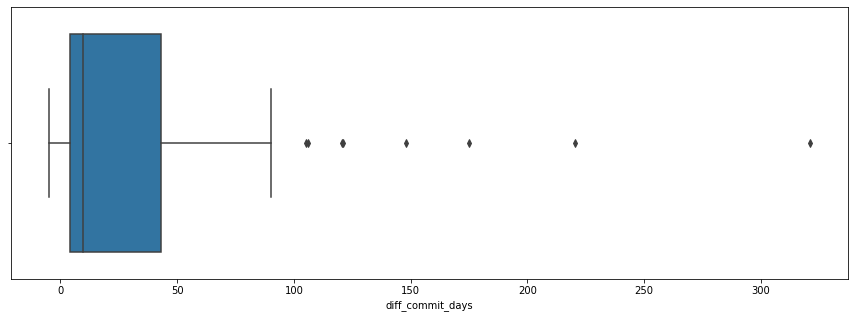

In [73]:
sns.boxplot(x=tags_comparison.diff_commit_days)

**Do pairs with negative days difference have a behind_by == 1 situation?**

In [74]:
tags_comparison[tags_comparison.diff_commit_days < 0]

,from_tag,from_author_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_author_date,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days
1669,5.4-RC2,2016-02-15 15:38:37,e8f951d9f2a99975e31f82d97fce68f47e9242d3,8909ccd99b9bc5874f24395519d66e2bcb9bdacb,36,1,5.5-M1,2016-02-12 15:43:47,37,-3 days +00:05:10,-2.996412,2016-02-15 16:38:37,2016-02-15 09:09:03,-1 days +16:30:26,-0.312199
1188,5.6.1,2016-07-25 08:13:12,4f37a3f3b40da4bba953d1ed9a2b0d114869a8ad,41affbb82c5e897eea64f77538ce4b20322ba61c,450,2,6.0-RC1,2016-07-20 08:30:19,452,-5 days +00:17:07,-4.988113,2016-07-25 10:13:12,2016-07-20 10:30:19,-5 days +00:17:07,-4.988113
113,7.9,2019-07-01 07:56:26,6502ec4ffee7e5a57498baaf330b80eb490d01c2,87ca68d63f4afd37d74b2f454430dfde9e862c6a,415,1,8.0,2019-10-15 08:15:12,416,106 days 00:18:46,106.013032,2019-10-17 15:24:45,2019-10-15 11:52:16,-3 days +20:27:31,-2.147558


Yes, this is the reason for the negative difference in days

**Pairs below the median**

In [75]:
len(tags_comparison[tags_comparison.diff_commit_days > tags_comparison.diff_commit_days.median()])

58

These could possibly be the versions with no bugs/issues reported

**Pais with smallest difference in days**

In [76]:
tags_comparison.loc[tags_comparison.diff_commit_days.idxmin()]

from_tag                                                5.6.1
from_author_date                          2016-07-25 08:13:12
from_sha             4f37a3f3b40da4bba953d1ed9a2b0d114869a8ad
to_sha               41affbb82c5e897eea64f77538ce4b20322ba61c
ahead_by                                                  450
behind_by                                                   2
to_tag                                                6.0-RC1
to_author_date                            2016-07-20 08:30:19
ahead_behind_sum                                          452
diff_author_dates                           -5 days +00:17:07
diff_author_days                                     -4.98811
from_commit_date                          2016-07-25 10:13:12
to_commit_date                            2016-07-20 10:30:19
diff_commit_dates                           -5 days +00:17:07
diff_commit_days                                     -4.98811
Name: 1188, dtype: object

**Difference in days: pairs outliers**

In [77]:
tags_comparison[tags_comparison.diff_commit_days > 100]

,from_tag,from_author_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_author_date,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days
2296,4.5.6,2015-10-16 09:31:18,12d931e5a31e1692a428bbb34ba11cd63aebf998,e2afb0bff1b8be759789d2c1bc9348de6f519f83,7,0,4.5.7,2016-04-08 13:44:39,7,175 days 04:13:21,175.175938,2015-10-16 11:31:18,2016-04-08 15:44:39,175 days 04:13:21,175.175938
1201,5.6.6,2017-02-16 20:34:26,05221592672b903c703c0424dc77458e615c106d,3de1bdeb3255fedc75885313205143f28aa89e9c,10,0,5.6.7,2017-09-25 10:46:49,10,220 days 14:12:23,220.591933,2017-02-16 21:34:26,2017-09-25 12:46:49,220 days 15:12:23,220.633600
344,6.7.5,2018-08-06 10:17:09,ec8ab77fa180a9edaf664075e8e76ae0b4a2d9f1,302f75de1ec5df6e983970f3c76b86ee02b1cd26,16,0,6.7.6,2018-11-19 15:51:14,16,105 days 05:34:05,105.232002,2018-08-06 12:17:09,2018-11-19 17:49:11,105 days 05:32:02,105.230579
325,6.7.6,2018-11-19 15:51:14,302f75de1ec5df6e983970f3c76b86ee02b1cd26,4aa6d928f960303eb990d50c275513a517c85e69,12,0,6.7.7,2019-04-16 15:38:04,12,147 days 23:46:50,147.990856,2018-11-19 17:49:11,2019-04-16 17:38:04,147 days 23:48:53,147.992280
268,7.0,2018-02-02 12:20:31,3b827a9a9a4b133c9fbe168aec8db44d78efeaeb,cb851ba202973bd468e070572c1e3b0b0437d2f4,1801,0,7.5,2018-12-18 09:56:40,1801,318 days 21:36:09,318.900104,2018-02-02 13:20:31,2018-12-20 11:41:48,320 days 22:21:17,320.931447
192,7.8,2019-06-18 09:08:04,870ae4efbf5dcdbe59295eb5827b55a6a74c7b89,6502ec4ffee7e5a57498baaf330b80eb490d01c2,141,0,7.9,2019-07-01 07:56:26,141,12 days 22:48:22,12.950255,2019-06-18 20:21:07,2019-10-17 15:24:45,120 days 19:03:38,120.794190
92,7.9.2,2019-12-09 13:03:50,5832fefc31f5ba25f15b3fa66ed816f7b87fd835,898a79cc7df01a9603c17f92b93e46ec62bc77d2,11,0,7.9.3,2020-03-24 07:49:27,11,105 days 18:45:37,105.781678,2019-12-09 20:53:13,2020-03-24 20:03:32,105 days 23:10:19,105.965498
73,7.9.3,2020-03-24 07:49:27,898a79cc7df01a9603c17f92b93e46ec62bc77d2,2f8d99a55899105cbf3e3170194c614c2a6ea4d7,14,0,7.9.4,2020-07-23 14:40:10,14,121 days 06:50:43,121.285220,2020-03-24 20:03:32,2020-07-23 20:05:45,121 days 00:02:13,121.001539


**Investigate the maximum difference in days value**

In [78]:
tags_comparison.loc[tags_comparison.diff_commit_days.idxmax()].to_frame()

,268
from_tag,7.0
from_author_date,2018-02-02 12:20:31
from_sha,3b827a9a9a4b133c9fbe168aec8db44d78efeaeb
to_sha,cb851ba202973bd468e070572c1e3b0b0437d2f4
ahead_by,1801
behind_by,0
to_tag,7.5
to_author_date,2018-12-18 09:56:40
ahead_behind_sum,1801
diff_author_dates,318 days 21:36:09


In [79]:
compare_tags[compare_tags.to_tag=="7.5"]

,from_tag,from_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_date
259,8.0,2019-10-15 08:15:12,87ca68d63f4afd37d74b2f454430dfde9e862c6a,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,1543,7.5,2018-12-18 09:56:40
260,7.9.4,2020-07-23 14:40:10,2f8d99a55899105cbf3e3170194c614c2a6ea4d7,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,1190,7.5,2018-12-18 09:56:40
261,7.9.3,2020-03-24 07:49:27,898a79cc7df01a9603c17f92b93e46ec62bc77d2,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,1176,7.5,2018-12-18 09:56:40
262,7.9.2,2019-12-09 13:03:50,5832fefc31f5ba25f15b3fa66ed816f7b87fd835,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,1165,7.5,2018-12-18 09:56:40
263,7.9.1,2019-07-10 12:20:33,6818fad17ba67e97d395a8488d5412e00892d5e1,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,1146,7.5,2018-12-18 09:56:40
264,7.9,2019-07-01 07:56:26,6502ec4ffee7e5a57498baaf330b80eb490d01c2,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,1129,7.5,2018-12-18 09:56:40
265,7.8,2019-06-18 09:08:04,870ae4efbf5dcdbe59295eb5827b55a6a74c7b89,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,988,7.5,2018-12-18 09:56:40
266,7.7,2019-03-19 16:29:12,69bc562d207053ef21afd12c8bc9c5217b50227a,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,479,7.5,2018-12-18 09:56:40
267,7.6,2019-01-21 15:04:13,c2edd480f08c8a692757df5ce6c89cddb566b666,cb851ba202973bd468e070572c1e3b0b0437d2f4,0,243,7.5,2018-12-18 09:56:40
268,7.0,2018-02-02 12:20:31,3b827a9a9a4b133c9fbe168aec8db44d78efeaeb,cb851ba202973bd468e070572c1e3b0b0437d2f4,1801,0,7.5,2018-12-18 09:56:40


We confirm that this is the best pairing. There seem to miss versions between 7.0 and 7.5 but they are not present on GitHub

### Ahead by distribution

<AxesSubplot:xlabel='ahead_by'>

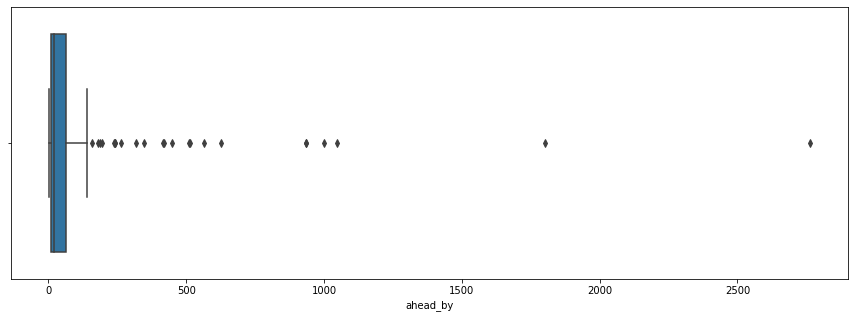

In [80]:
sns.boxplot(x=tags_comparison.ahead_by)

In [81]:
tags_comparison

,from_tag,from_author_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_author_date,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days
2307,4.5.5,2015-07-30 10:02:58,cc8a9472c671598fb3158b51b15863448a477a50,12d931e5a31e1692a428bbb34ba11cd63aebf998,16,0,4.5.6,2015-10-16 09:31:18,16,77 days 23:28:20,77.978009,2015-07-30 12:02:58,2015-10-16 11:31:18,77 days 23:28:20,77.978009
2296,4.5.6,2015-10-16 09:31:18,12d931e5a31e1692a428bbb34ba11cd63aebf998,e2afb0bff1b8be759789d2c1bc9348de6f519f83,7,0,4.5.7,2016-04-08 13:44:39,7,175 days 04:13:21,175.175938,2015-10-16 11:31:18,2016-04-08 15:44:39,175 days 04:13:21,175.175938
2257,5.1,2015-04-02 08:09:45,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,7,0,5.1.1,2015-06-02 08:34:06,7,61 days 00:24:21,61.016910,2015-04-02 10:09:45,2015-06-02 10:34:06,61 days 00:24:21,61.016910
2271,5.1-RC2,2015-03-23 15:22:47,dfc9f94b72103ee941cc11da6529623fa91df509,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,17,0,5.1,2015-04-02 08:09:45,17,9 days 16:46:58,9.699282,2015-03-23 16:22:47,2015-04-02 10:09:45,9 days 17:46:58,9.740949
2242,5.1.1,2015-06-02 08:34:06,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,12,0,5.1.2,2015-07-27 08:03:21,12,54 days 23:29:15,54.978646,2015-06-02 10:34:06,2015-07-27 10:03:21,54 days 23:29:15,54.978646
2226,5.1.2,2015-07-27 08:03:21,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,d5dd7720eb79dc0cae1a1b38f83e757a031f8ca9,2762,0,5.2-RC1,2015-10-12 15:58:42,2762,77 days 07:55:21,77.330104,2015-07-27 10:03:21,2015-10-12 17:58:42,77 days 07:55:21,77.330104
2172,5.2,2015-11-02 08:56:19,f045be98be3ba032b6b19d71574038eeeb91803b,c979578645aaf77c447b250136db32a7067619a1,513,0,5.3-RC1,2015-12-09 12:47:34,513,37 days 03:51:15,37.160590,2015-11-02 09:56:19,2015-12-09 13:47:34,37 days 03:51:15,37.160590
2209,5.2-RC1,2015-10-12 15:58:42,d5dd7720eb79dc0cae1a1b38f83e757a031f8ca9,3d2b3bbd084ccf75d1921382315d3ac3037ed3bc,4,0,5.2-RC2,2015-10-13 10:06:23,4,0 days 18:07:41,0.755336,2015-10-12 17:58:42,2015-10-13 12:06:23,0 days 18:07:41,0.755336
2191,5.2-RC2,2015-10-13 10:06:23,3d2b3bbd084ccf75d1921382315d3ac3037ed3bc,ef358b002383f918448dcb5e8ac40b64a35a4c26,56,0,5.2-RC3,2015-10-20 13:47:33,56,7 days 03:41:10,7.153588,2015-10-13 12:06:23,2015-10-20 15:47:33,7 days 03:41:10,7.153588
2153,5.3-RC1,2015-12-09 12:47:34,c979578645aaf77c447b250136db32a7067619a1,29a84111f6cc9298f83df515830ff40a41d0976c,40,1,5.3-RC2,2015-12-17 16:02:01,41,8 days 03:14:27,8.135035,2015-12-09 13:47:34,2015-12-17 17:02:01,8 days 03:14:27,8.135035


**Let's investigate the outliers**

In [82]:
tags_comparison[tags_comparison.ahead_by > 200][["from_tag", "to_tag", "ahead_by"]]

,from_tag,to_tag,ahead_by
2226,5.1.2,5.2-RC1,2762
2172,5.2,5.3-RC1,513
1372,5.5,5.6-RC1,318
1188,5.6.1,6.0-RC1,450
1105,6.0,6.1-RC1,564
1044,6.1.1,6.2-RC1,627
874,6.2.1,6.3-RC1,936
873,6.2.1,6.3.0.18401,936
731,6.3.2,6.4-RC1,1001
515,6.5,6.6-RC1,1046


**Investigate the pairs with smallest ahead_by**

In [100]:
tags_comparison.sort_values(by="ahead_by").head(5)[["from_tag", "to_tag", "ahead_by"]]

,from_tag,to_tag,ahead_by
590,6.5-RC1,6.5-M3,1
553,6.5-RC2,6.5-M4,1
2115,5.3-RC3,5.3,2
1391,5.5-RC2,5.5,3
1220,5.6.5,5.6.6,3


**Investigate minumum ahead_by**

In [88]:
tags_comparison.loc[tags_comparison.ahead_by.idxmin()].to_frame()

,590
from_tag,6.5-RC1
from_author_date,2017-07-13 17:11:40
from_sha,3861f8769afa40e556c63ff7f39a41f9f89f68fa
to_sha,ca28dd4ed34ab7c6e6066dd44820fe815c21b7a8
ahead_by,1
behind_by,0
to_tag,6.5-M3
to_author_date,2017-07-13 17:56:59
ahead_behind_sum,1
diff_author_dates,0 days 00:45:19


We would expect 6.5-M3 to be paired with 6.5-M2 if it exists. Let's see how 6.5-M3 performed when compared with the other tags.

In [97]:
compare_tags[(compare_tags.ahead_by>0)&(compare_tags.behind_by<2)]\
[compare_tags.to_tag=="6.5-M3"].sort_values(by="ahead_by").head(5)

<ipython-input-97-e460f6b9cc9a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  compare_tags[(compare_tags.ahead_by>0)&(compare_tags.behind_by<2)]\


,from_tag,from_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_date
590,6.5-RC1,2017-07-13 17:11:40,3861f8769afa40e556c63ff7f39a41f9f89f68fa,ca28dd4ed34ab7c6e6066dd44820fe815c21b7a8,1,0,6.5-M3,2017-07-13 17:56:59
592,6.5-M2,2017-07-05 17:09:06,bcc8082815b493171a30ae32dfef9d9c278804a4,ca28dd4ed34ab7c6e6066dd44820fe815c21b7a8,67,0,6.5-M3,2017-07-13 17:56:59
594,6.4,2017-06-02 08:32:25,ad64a17b531c0e1f6fef0ce7e4d0d0b060977754,ca28dd4ed34ab7c6e6066dd44820fe815c21b7a8,392,0,6.5-M3,2017-07-13 17:56:59
595,6.4-RC3,2017-05-29 09:55:18,1f978d91e82d8ddbe49806ee6d32bc93e8f6a42f,ca28dd4ed34ab7c6e6066dd44820fe815c21b7a8,403,0,6.5-M3,2017-07-13 17:56:59
596,6.4-RC2,2017-05-22 10:00:44,8e826b1066ffea29958f8c5ac09244baa624dafd,ca28dd4ed34ab7c6e6066dd44820fe815c21b7a8,415,0,6.5-M3,2017-07-13 17:56:59


6.5-M2 is in the list and is a fast-forward of only 67 commits. However, 6.5-M3 seems more similar to 6.5-RC1. Let's see if 6.5-M2 has been used as "from_tag" and with which tag.

In [92]:
tags_comparison[tags_comparison.from_tag=="6.5-M2"]

,from_tag,from_author_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_author_date,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days,to_commit_date_month,to_commit_date_year
610,6.5-M2,2017-07-05 17:09:06,bcc8082815b493171a30ae32dfef9d9c278804a4,3861f8769afa40e556c63ff7f39a41f9f89f68fa,66,0,6.5-RC1,2017-07-13 17:11:40,66,8 days 00:02:34,8.001782,2017-07-05 19:09:06,2017-07-13 19:11:40,8 days 00:02:34,8.001782,7,2017


It has been correclty paired with 6.5-RC1.

**Investigate maximum ahead_by**

In [99]:
tags_comparison.loc[tags_comparison.ahead_by.idxmax()].to_frame()

,2226
from_tag,5.1.2
from_author_date,2015-07-27 08:03:21
from_sha,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c
to_sha,d5dd7720eb79dc0cae1a1b38f83e757a031f8ca9
ahead_by,2762
behind_by,0
to_tag,5.2-RC1
to_author_date,2015-10-12 15:58:42
ahead_behind_sum,2762
diff_author_dates,77 days 07:55:21


**Number of ahead commits distribution over time**

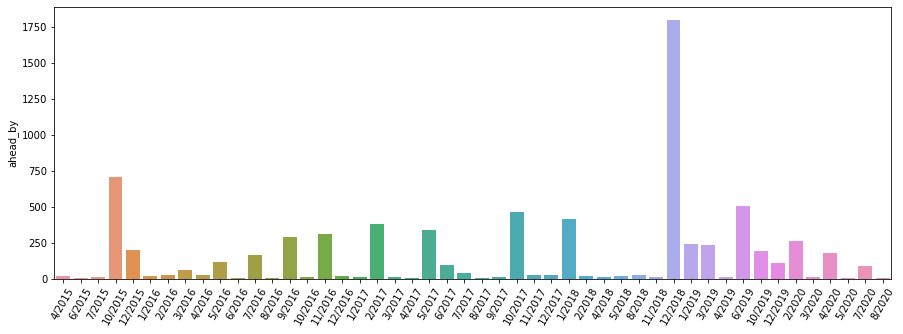

In [83]:
tags_comparison["to_commit_date_month"] = tags_comparison.to_commit_date.dt.month
tags_comparison["to_commit_date_year"] = tags_comparison.to_commit_date.dt.year

data = tags_comparison.groupby(["to_commit_date_year","to_commit_date_month"]).ahead_by.mean().reset_index()
ax = sns.barplot(y = data.ahead_by, x= data.apply(lambda row: f"{str(int(row.to_commit_date_month))}/{str(int(row.to_commit_date_year))}", axis=1))
ax.tick_params(axis='x', labelrotation= 60)

<AxesSubplot:xlabel='to_commit_date_year', ylabel='ahead_by'>

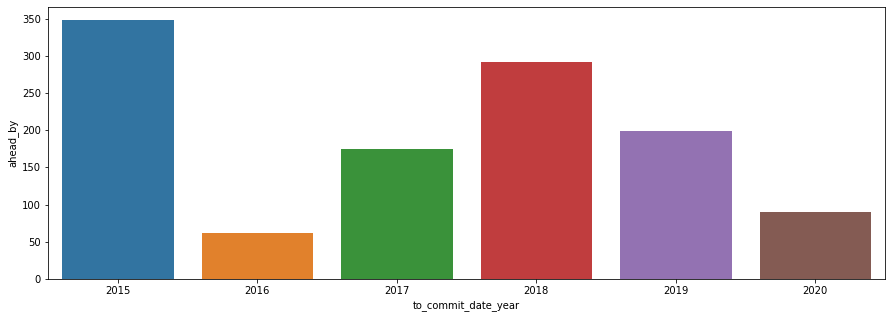

In [84]:
data = tags_comparison.groupby(["to_commit_date_year"]).ahead_by.mean().reset_index()
sns.barplot(y=data.ahead_by, x=data.to_commit_date_year)

* The difference in days between 2 tags is negative: we should not worry about this. Some tags have been compared with one behind of it of at most 1 commit. The negative difference is be due to this extra commit.
* Tag 7.5 has a 320 days difference with its tag comparison (7.0). We double checked on GitHub and there are no versions between 7.0 and 7.5 and our comparisons with other tags confirm that 7.0 is the most similar to 7.5
* All the outliers in number of ahead_commits are changes to at least minor version in some cases major.